# Texas House and Texas Senate District Mappings

## Importing the Files

In [64]:
import pandas as pd
import warnings
import re

## Ignore warnings
warnings.filterwarnings("ignore")  # Comment out if WANT warnings

## File names - PLEASE INPUT
fileName = "SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx"

## Variables
if re.search("\.xlsx$", fileName):
    filePath_excel = f"./data/{fileName}"
elif re.search("\.csv$", fileName):
    filePath_csv = f"./data/{fileName}"
else:
    print(f"File format not supported (xlsx or csv needed).")

## Import excel file
df = pd.read_excel(filePath_excel, engine="openpyxl")
# display(df.head())  # Show head of dataframe

## Import csv file - Uncomment if need to import CSV
# df = pd.read_csv(filePath_csv)
# display(df.head())  # Show head of the dataframe


## Subset the columns
mask_address_cols = ["Billing Address", "Billing City", "Billing State/Province", "Billing Zip/Postal Code"]
# display(df[mask_address_cols].head())  # Show head of dataframe subset


## Check missing values and filter out missing rows
mask_no_missing_val = df[mask_address_cols].isna().sum(axis=1).apply(lambda x: True if x==0 else False)
df_no_missing_val = df.loc[mask_no_missing_val, mask_address_cols]  # dataframe subset without missing addresses


In [65]:
## Create 'Full Address' column in DataFrame
## NOTES: 
## - Rows with missing values are skipped

## Helper function
def joinAddress(row):
    '''Joins compound address fields into single string.
    
    The function also strings leading and trailing spaced that causes issues with .tab
    '''
    if (isinstance(row[mask_address_cols[0]], float) | 
        isinstance(row[mask_address_cols[1]], float) | 
        isinstance(row[mask_address_cols[2]], float) | 
        isinstance(row[mask_address_cols[3]], float)):
        print(f"This is invalid: ")
        print(row)
    return(str(row[mask_address_cols[0]]).strip() + ", " + 
           row[mask_address_cols[1]].strip() + ", " + 
           row[mask_address_cols[2]].strip() + " " + 
           str(row[mask_address_cols[3]]).strip())
    
## Create a new column `full_address`
df.loc[mask_no_missing_val, "full_address"] = df.loc[mask_no_missing_val, mask_address_cols].apply(joinAddress, axis=1)
display(df[(mask_address_cols + ["full_address"])])  # Display the new dataframe subset

,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,full_address
0,2407 S. Houston,Amarillo,TX,79103,"2407 S. Houston, Amarillo, TX 79103"
1,3901 SE 15th,Amarillo,TX,79104,"3901 SE 15th, Amarillo, TX 79104"
2,3800 S. Lipscomb,Amarillo,TX,79110,"3800 S. Lipscomb, Amarillo, TX 79110"
3,3209 S. Taylor,Amarillo,TX,79110,"3209 S. Taylor, Amarillo, TX 79110"
4,2215 S. Bivins,Amarillo,TX,79103,"2215 S. Bivins, Amarillo, TX 79103"
...,...,...,...,...,...
677,900 Ave Q,Sunray,TX,79086,"900 Ave Q, Sunray, TX 79086"
678,1701 23rd St,Canyon,TX,79015,"1701 23rd St, Canyon, TX 79015"
679,5800 Attebury Dr,Canyon,TX,79118,"5800 Attebury Dr, Canyon, TX 79118"
680,1401 23rd St,Canyon,TX,79015,"1401 23rd St, Canyon, TX 79015"


In [66]:
## Checking addresses
## NOTES:
## - Troulbing address are PO box
## - 1600B is a valid address, there is not a space between door number and `B`

df["full_address"].str.match(r"^(\d+ \w+)").value_counts()  # There are 4 bad address

mask_good_address = df["full_address"].str.match(r"^(\d+ \w+)").astype(bool)

temp = df.loc[~mask_good_address, mask_address_cols]
display(temp)


,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code
222,Po Box 191405,Dallas,TX,75219-1405
593,1600B Smith Rd,Austin,TX,78721-3541


In [74]:
## Helper functions for Google API

## Google Maps API
import os
apiKey_googleMaps = os.environ['apiKey_googleMaps']

## Import Google Geocoder
from geopy.geocoders import GoogleV3
geolocator = GoogleV3(api_key=apiKey_googleMaps)


## Helper function: Extract latitude and longitude
def extract_lat_long(address):
    try:
        location = geolocator.geocode(address)
        return (location.latitude, location.longitude)
    except:
        return ""

## Helper function: Extract standardized and formatted address
def extract_clean_address(address):
    try:
        location = geolocator.geocode(address)
        return location.address
    except:
        return ""
    
## Helper function: Extract raw
def extract_raw(address):
    try:
        location = geolocator.geocode(address)
        return location.raw
    except:
        return ""

In [69]:
## Added googleMaps_lat_long and googleMaps_clean_address columns
df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_lat_long)
df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_clean_address)

## Testing
# df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_lat_long)
# df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_clean_address)



In [78]:
## Testing
## NOTES: 
## - Sometimes when Google API can't find the result, it returns just the city.
## - Google Maps data are crowdsourced and can be incorrect, such as San Jacinto Elementary School below
## - May want to look into USPS option

## Test Raw - Google Maps API provides raw data access as well
# print(extract_raw(df.loc[3, 'full_address']))
# print(extract_raw("200 Ave F, Hereford, TX 79045"))

## Issues Test
# print(extract_raw("3400 W. 4th, Amarillo, TX 79106"))  # Google Maps returns the city Amarillo, Google Maps address does not match USPS


{'address_components': [{'long_name': '3209', 'short_name': '3209', 'types': ['street_number']}, {'long_name': 'South Taylor Street', 'short_name': 'S Taylor St', 'types': ['route']}, {'long_name': 'Amarillo', 'short_name': 'Amarillo', 'types': ['locality', 'political']}, {'long_name': 'Randall County', 'short_name': 'Randall County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'Texas', 'short_name': 'TX', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '79110', 'short_name': '79110', 'types': ['postal_code']}, {'long_name': '1038', 'short_name': '1038', 'types': ['postal_code_suffix']}], 'formatted_address': '3209 S Taylor St, Amarillo, TX 79110, USA', 'geometry': {'bounds': {'northeast': {'lat': 35.1789477, 'lng': -101.8390879}, 'southwest': {'lat': 35.1788622, 'lng': -101.8392872}}, 'location': {'lat': 35.1788868, 'lng': -101.8391701}, 'location_type

In [70]:
## Exporting data
## NOTES:
## - full_address have commas, thus can cause issues when exporting as CSV
## - Instead, use tab as delimiter (.tab files)

## Date suffix - To help differentiate exported files
from datetime import datetime as dt
date_suffix = (dt.now().strftime("%Y%m%d_%H%M_%S_%f"))  # Date/Time/Microsecond to differentiate files

## Export file to excel
df.to_excel(f"data/{fileName}_cleanFile_{date_suffix}.xlsx")  # Export to xlsx

## Export .tab (tab delimited files) - Can be opened with Excel
df.to_csv(f"data/{fileName}_cleanFile_{date_suffix}.tab", sep="\t")

## Points in Polygon (Finding which district an address belongs to)

In [10]:
### Summary >>> [Source](https://redistricting.capitol.texas.gov/history)
##
## Texas Congressional Districts
## - Texas Senate Districts: 
##    - 2002-2010 - Plan01188S
##    - 2012-2020 - PlanS172
##    - 2022 (Primary and general elections) - SB 4 - PlanS2168
##
## - Texas House Districts: 
##    - 2002-2010 - Plan01369H
##    - 2012 - PlanH309
##    - 2014-2018 - PlanH358
##    - 2020 - PlanH414
##    - 2022 (Primary and general elections) - HB 1 - PlanH2316
## - Texas Board of Education Districts: 
##    - 2022 (Primary and general elections) - SB 7 - PlanE2106
##
## Texas Congressional Districts (US House Districts in Texas)
##    - 2002 - PLAN01151C
##    - 2004-2006 - PLAN01374C
##    - 2006-2010 - PLAN01440C
##    - 2012-2020 - PLANC235
##    - 2022 (Primary and general elections) - SB 6 - PlanC193

In [85]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [182]:
## read file
df = pd.read_excel("./data/SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx_cleanFile_20220725_1506_44_883408.xlsx", engine="openpyxl")
# display(df)

## Change lat/long file type from str -> tuple
df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "googleMaps_lat_long"].apply(lambda row: tuple([float(i) for i in row.strip("()").split(", ")[::-1]]))
df.loc[mask_no_missing_val, "coords"] = df.loc[mask_no_missing_val, "googleMaps_lat_long"].apply(Point)

(-101.8237399, 35.1875439)


In [143]:
## Texas House Districts
txHouse = gpd.GeoDataFrame.from_file("/Users/anthonylee/Downloads/PLANH2316/PLANH2316.shp")
print(txHouse)
print(txHouse.crs)

## Convert CRS (Coordinate Ref Sys) to WGS84
txHouse = txHouse.to_crs("WGS84")
print(txHouse)
print(txHouse.crs)

     District                                           geometry
0           1  POLYGON ((1494406.980 1201348.426, 1494404.818...
1           2  POLYGON ((1368626.668 1138307.981, 1368617.076...
2           3  POLYGON ((1455820.856 884283.339, 1455817.544 ...
3           4  POLYGON ((1366839.633 1106996.402, 1366810.030...
4           5  POLYGON ((1470631.844 1131634.573, 1470630.166...
..        ...                                                ...
145       146  POLYGON ((1442742.810 837343.344, 1442774.750 ...
146       147  POLYGON ((1459168.977 836342.385, 1459166.055 ...
147       148  POLYGON ((1438324.259 856819.707, 1438316.111 ...
148       149  POLYGON ((1425314.465 841876.921, 1425205.233 ...
149       150  POLYGON ((1430608.983 882191.471, 1430607.985 ...

[150 rows x 2 columns]
PROJCS["NAD_1983_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Gre

0      POINT (-101.82374 35.18754)
1      POINT (-101.79088 35.19671)
2      POINT (-101.85456 35.17375)
3      POINT (-101.83917 35.17889)
4      POINT (-101.80683 35.18754)
                  ...             
677    POINT (-101.82022 36.01350)
678    POINT (-101.91584 34.96579)
679    POINT (-101.89897 35.11288)
680    POINT (-101.91887 34.96941)
681    POINT (-101.75766 34.54193)
Name: coords, Length: 672, dtype: geometry


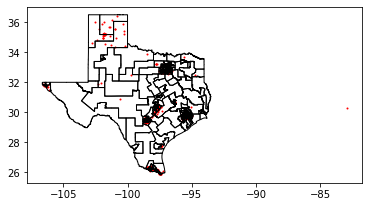

     District                                           geometry
0           1  POLYGON ((-94.70577 32.87916, -94.70579 32.879...
1           2  POLYGON ((-96.07526 32.35748, -96.07537 32.357...
2           3  POLYGON ((-95.26368 30.03251, -95.26371 30.032...
3           4  POLYGON ((-96.10600 32.07531, -96.10632 32.075...
4           5  POLYGON ((-94.99376 32.26004, -94.99376 32.260...
..        ...                                                ...
145       146  POLYGON ((-95.41960 29.61362, -95.41922 29.614...
146       147  POLYGON ((-95.25031 29.59833, -95.25034 29.598...
147       148  POLYGON ((-95.45699 29.79114, -95.45702 29.792...
148       149  POLYGON ((-95.59784 29.66096, -95.59895 29.661...
149       150  POLYGON ((-95.52624 30.02310, -95.52625 30.023...

[150 rows x 2 columns]


In [184]:
df.loc[mask_no_missing_val, "coords"] = df.loc[mask_no_missing_val, "googleMaps_lat_long"].apply(Point)
txHouse_points = gpd.GeoDataFrame(df.loc[mask_no_missing_val, :], geometry="coords", crs=txHouse.crs)
txHouse_pointsInPolys = gpd.tools.sjoin(txHouse_points, txHouse, predicate="within", how="left")

## Plot
base = txHouse.boundary.plot(linewidth=1, edgecolor="black")
txHouse_pointsInPolys.plot(ax=base, linewidth=1, color="red", markersize=1)
print(txHouse_pointsInPolys.coords)
plt.show()

## 
# print(txHouse_pointsInPolys)
print(txHouse)

In [24]:
# Generate random points
N = 10000
lat = np.random.uniform(23, 51, N)
lon = np.random.uniform(-126, -64, N)

# Create geodataframe from numpy arrays
df2 = pd.DataFrame({"lon":lon, "lat":lat})
df2['coords'] = list(zip(df2['lon'], df2['lat']))
df2['coords'] = df2['coords'].apply(Point)

points = gpd.GeoDataFrame(df2, geometry="coords", crs=txHouse.crs)

In [25]:
## Spatial join
pointInPolys = gpd.tools.sjoin(points, txHouse, predicate="within", how="left")

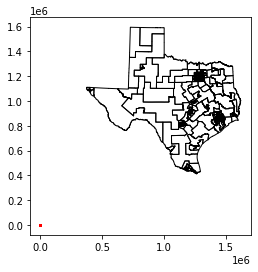

In [27]:
# Plot map
base = txHouse.boundary.plot(linewidth=1, edgecolor='black')
points.plot(ax=base, linewidth=1, color='red', markersize=1)
plt.show()

In [34]:
type(pointInPolys)
print(pointInPolys.columns)

mask = pointInPolys.District.isna()
print(pointInPolys.District[mask==False])

print(mask.sum())
print(len(mask))

Index(['lon', 'lat', 'coords', 'index_right', 'District'], dtype='object')
Series([], Name: District, dtype: float64)
10000
10000
